# Utilizando Machine Learning para Previsão de Inadimplência

## Exposição do problema

Este artigo é a apresentação do projeto final do curso de Data Science da Awari. 

O objetivo deste trabalho consiste em analisar os dados disponibilizados pelo Banco Central do Brasil relacionados à inadimplência empresarial dentro do contexto brasileiro.

De acordo com Serasa, mais de 5 milhões de pequenas empresas se endividaram na pandemia e estão inadimplentes. 

Essas tiveram que recorrer a empréstimos com instituições financeiras para sobreviver durante a pandemia, e agora estão tendo dificuldades para pagar as parcelas.

Pensando nisto, resolvi realizar este projeto onde vamos verificar a previsão de uma empresa ficar inadimplente.

Obs: Os dados utilizados foram retirados do site do BACEN: https://dadosabertos.bcb.gov.br/dataset/scr_data

## Importação de Pacotes

A primeira tarefa é fazer a importação dos pacotes que serão utilizados no algoritmo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sweetviz as sv

import warnings
warnings.filterwarnings('ignore')

## Leitura dos dados

Após a importação dos pacotes vamos realizar a leitura dos dados do arquivo baixado.

In [2]:
df = pd.read_csv('dados_bc_2021_11.csv', sep=';')
df.head()

,uf,tcb,sr,cliente,cnae_secao,cnae_subclasse,porte,modalidade,origem,indexador,...,a_vencer_ate_90_dias,a_vencer_de_91_ate_360_dias,a_vencer_de_361_ate_1080_dias,a_vencer_de_1081_ate_1800_dias,a_vencer_de_1801_ate_5400_dias,a_vencer_acima_de_5400_dias,vencido_acima_de_15_dias,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico
0,AC,Bancário,S1,PJ,"PJ - Administração pública, defesa e seguridad...",-,PJ - Micro,PJ - Capital de giro,Sem destinação específica,Flutuantes,...,"1205677,52","2951544,24","7870784,64","7542835,28","14101828,32",0,0,33672670,0,0
1,AC,Bancário,S1,PJ,"PJ - Administração pública, defesa e seguridad...",-,PJ - Micro,PJ - Financiamento de infraestrutura/desenvolv...,Com destinação específica,Flutuantes,...,"1444428,27","4395932,84","11821330,14","11590794,08","19605221,57",0,0,"48857706,9",0,0
2,AC,Bancário,S1,PJ,"PJ - Administração pública, defesa e seguridad...",-,PJ - Micro,PJ - Financiamento de infraestrutura/desenvolv...,Com destinação específica,Pós-fixado,...,"2341072,72","6807699,62","14364730,68","11159167,98","39279188,09","2717878,98",0,"76669738,07",0,0
3,AC,Bancário,S1,PJ,"PJ - Administração pública, defesa e seguridad...",-,PJ - Pequeno,PJ - Capital de giro rotativo,Sem destinação específica,Prefixado,...,0,"498,66",0,0,0,0,0,"498,66",0,0
4,AC,Bancário,S1,PJ,"PJ - Administração pública, defesa e seguridad...",-,PJ - Pequeno,PJ - Outros créditos,Sem destinação específica,Prefixado,...,"9147,12","18393,16","45713,32","39605,21","6497,9",0,"2151,69","121508,4",0,0


In [3]:
df.columns #Informações das colunas

Index(['uf', 'tcb', 'sr', 'cliente', 'cnae_secao', 'cnae_subclasse', 'porte',
       'modalidade', 'origem', 'indexador', 'numero_de_operacoes',
       'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias',
       'a_vencer_de_361_ate_1080_dias', 'a_vencer_de_1081_ate_1800_dias',
       'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias',
       'vencido_acima_de_15_dias', 'carteira_ativa',
       'carteira_inadimplida_arrastada', 'ativo_problematico'],
      dtype='object')

**UF**- O total nacional mais as 27 unidades da federação estão presentes no relatório. A informação segregada
por unidades da federação é baseada no CEP de residência das pessoas físicas ou da Sede das pessoas
jurídicas.

**TCB (Tipo de Consolidado Bancário)** - Agrupado da seguinte forma: 
 * Bancário (agregação de B1 - Banco comercial, banco múltiplo com carteira comercial ou caixas econômicas, B2 -    Banco múltiplo sem carteira comercial ou banco de câmbio ou banco de investimento e B4 - Banco de desenvolvimento) 
 * Não Bancário (agregação de N1 - Não bancário de crédito, N2 - Não bancário do mercado de capitais e N4 - Instituições de pagamento) 
 * Cooperativas (B3S - Cooperativa de crédito singular e B3C - Central e confederação de cooperativas de crédito)
 
**SR (Segmento Resolução no 4.553/2017)** - Agrupado da seguinte forma:
 * S1 - Bancos múltiplos, bancos comerciais, bancos de investimento, bancos de câmbio e caixas econômicas
que tenham porte (Exposição/Produto Interno Bruto) superior a 10% ou exerçam atividade internacional
relevante (ativos no exterior superiores a US$ 10 bilhões).
 * S2 - Bancos múltiplos, bancos comerciais, bancos de investimento, bancos de câmbio e caixas econômicas
de porte inferior a 10% e igual ou superior a 1% e demais instituições autorizadas a funcionar pelo Banco
Central do Brasil de porte igual ou superior a 1% do PIB.
 * S3 - Instituições de porte inferior a 1% e igual ou superior a 0,1%.
 * S4 - Instituições de porte inferior a 0,1%.
 * S5 - Composto por instituições de porte inferior a 0,1% que utilizem metodologia facultativa simplificada
para apuração dos requerimentos mínimos de Patrimônio de Referência (PR), de Nível I e de Capital
Principal, exceto bancos múltiplos, bancos comerciais, bancos de investimento, bancos de câmbio e caixas
econômicas e não sujeitas a apuração de PR.

**Código Nacional de Atividades Econômicos / CNAE (Pessoas Jurídicas)**- O CNAE disponível para visualização em formato gráfico refere-se às pessoas jurídicas e possui 21 seções e seus agrupamentos podem ser consultados no site do Instituto Brasileiro de Geografia e Estatísticas - IBGE. No portal de dados abertos

**Porte dos clientes** - O porte dos clientes está agrupado da seguinte forma: 
 * PJ - Micro 
 * PJ - Pequeno 
 * PJ - Médio
 * PJ - Grande

**Modalidade** - As modalidades das operações de crédito estão agrupadas da seguinte forma:
 * PJ - Capital de giro rotativo 
 * PJ - Financiamento de infraestrutura
 * PJ - Investimento
 * PJ - Operações com recebíveis
 * PJ - Outros créditos
 * PJ - Rural e agroindustrial
 * PJ - Capital de giro
 * PJ - Comércio exterior
 * PJ - Habitacional.

As modalidades apresentadas no relatório representam uma agregação das submodalidades disponíveis no Anexo 3 do Leiaute do SCR, disponível em https://www.bcb.gov.br/estabilidadefinanceira/scrdoc3040, e disponibilizadas no  IF.data - https://www3.bcb.gov.br/ifdata/.

**Origem de recursos** - A origem dos recursos está agrupada da seguinte forma: 
 * Sem destinação específica 
 * Com destinação específica

**Indexador da operação** - Os indexadores da operação estão agrupados da seguinte forma: 
 * Prefixado
 * Pós-fixado
 * Flutuantes
 * Índices de preços
 * TCR/TRFC*
 * Outros indexadores
 
**Número de Operações:** Representa o número de operações de crédito para uma dada série. Casos em que o número de
operações seja inferior ou igual a 15, a informação divulgada será “<= 15”.

**Valores a vencer até 90 dias:** Somatório dos créditos a vencer até 90 dias.

**Valores a vencer de 91 a 360 dias:** Somatório dos créditos a vencer de 91 até 360 dias.

**Valores a vencer de 361 até 1080 dias:** Somatório dos créditos a vencer de 361 até 1080 dias.

**Valores a vencer de 1081 até 1800 dias:** Somatório dos créditos a vencer de 1081 até 1800 dias.

**Valores a vencer de 1801 até 5400 dias:** Somatório dos créditos a vencer de 1801 até 5400 dias.

**Valores a vencer acima de 5400 dias:** Somatório dos créditos a vencer acima de 5400 dias.

**Valores vencidos acima de 15 dias:** Somatório dos créditos vencidos acima de 15 dias.

**Carteira total:** Somatório dos itens valores a vencer.

**Carteira inadimplida arrastada:** Somatório das operações de crédito a vencer e vencidos que possuam alguma parcela vencida há mais de 90 dias.

**Ativos problemáticos:** Somatório dos créditos das operações de crédito classificadas com risco entre E e H, operações reestruturadas e das operações consideradas na carteira inadimplida arrastada.

## Limpeza dos dados

Várias colunas apresentam os números no formato texto, porém precisamos os números em formato numérico. Poranto vamos transformá-los de texto para numérico.

In [4]:
#transformando números texto em números float
df['carteira_inadimplida_arrastada'] = df['carteira_inadimplida_arrastada'].str.replace(',', '.').astype(float)
df['ativo_problematico'] = df['ativo_problematico'].str.replace(',', '.').astype(float)
df['vencido_acima_de_15_dias'] = df['vencido_acima_de_15_dias'].str.replace(',', '.').astype(float)
df['numero_de_operacoes'] = df['numero_de_operacoes'].str.replace('<= 15', '1').astype(int)

Como queremos fazer uma classificação se uma empresa vai inadimplir ou não, vamos criar colunar que facilitam essa classificação.

A coluna 'vencido_acima_de_15_dias' possui os valores que a empresa possui vencidos acima de 15 dias, com isso vamos criar a coluna 'possui_v15' indicando somente se possui valores vencidos acima de 15 dias.

A coluna 'carteira_inadimplida_arrastada' possui os valores que a empresa possui vencidos com mais de 90 dias, com isso vamos criar a coluna 'possui_cia' indicando somente se possui valores vencidos com mais de 90 dias.

A coluna 'ativo_problematico' é onde possui os valores que a empresa possui efetivamente inadimplidos, com isso vamos criar a coluna 'possui_ap' indicando somente se possui valores inadimplidos.

In [5]:
#incluindo colunas verdaderio ou falso
df['possui_v15'] = np.where(df['vencido_acima_de_15_dias'] == 0, 'Não', 'Sim')
df['possui_cia'] = np.where(df['carteira_inadimplida_arrastada'] == 0, 'Não', 'Sim')
df['possui_ap'] = np.where(df['ativo_problematico'] == 0, 'Não', 'Sim')

Por fim vamos eliminar as colunas que não iremos utilizar para a nossa previsão.

In [6]:
#eliminando colunas
df.drop(['cnae_subclasse', 'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias', 
         'a_vencer_de_361_ate_1080_dias', 'a_vencer_de_1081_ate_1800_dias', 
         'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias', 'carteira_inadimplida_arrastada',
         'cliente', 'ativo_problematico', 'vencido_acima_de_15_dias', 'carteira_ativa'], axis=1, inplace=True)

Vamos fazer a verificação de valores nulos, e pudemos notar que esse DataFrame não possui nenhum valor nulo.

In [7]:
df.isnull().sum()

uf                     0
tcb                    0
sr                     0
cnae_secao             0
porte                  0
modalidade             0
origem                 0
indexador              0
numero_de_operacoes    0
possui_v15             0
possui_cia             0
possui_ap              0
dtype: int64

## Informações do DataFrame

Algumas informaçoes sobre nosso DataFrame

In [8]:
df.shape #Dimensão e proporção dos dados

(656958, 12)

In [9]:
df.info() #Informações do DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656958 entries, 0 to 656957
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   uf                   656958 non-null  object
 1   tcb                  656958 non-null  object
 2   sr                   656958 non-null  object
 3   cnae_secao           656958 non-null  object
 4   porte                656958 non-null  object
 5   modalidade           656958 non-null  object
 6   origem               656958 non-null  object
 7   indexador            656958 non-null  object
 8   numero_de_operacoes  656958 non-null  int64 
 9   possui_v15           656958 non-null  object
 10  possui_cia           656958 non-null  object
 11  possui_ap            656958 non-null  object
dtypes: int64(1), object(11)
memory usage: 60.1+ MB


## Analise Exploratória

In [10]:
# calcular porcentagem de inadimplentes por porte
df2 = df.groupby(['porte', 'possui_ap'])['possui_ap'].count()
df3 = df2.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
print(df3)

porte                                          possui_ap
PJ - Grande                                    Não          94.760298
                                               Sim           5.239702
PJ - Micro                                     Não          65.130758
                                               Sim          34.869242
PJ - Médio                                     Não          83.696810
                                               Sim          16.303190
PJ - Pequeno                                   Não          69.018913
                                               Sim          30.981087
Name: possui_ap, dtype: float64


Acima vemos a porcentagem de inadimplentes agrupados por porte da empresa, e pudemos notar que quanto menor o porte da empresa maior é o indice de inadimplencia.

Abaixo vemos o mesmo indice porém em gráfico de barras.

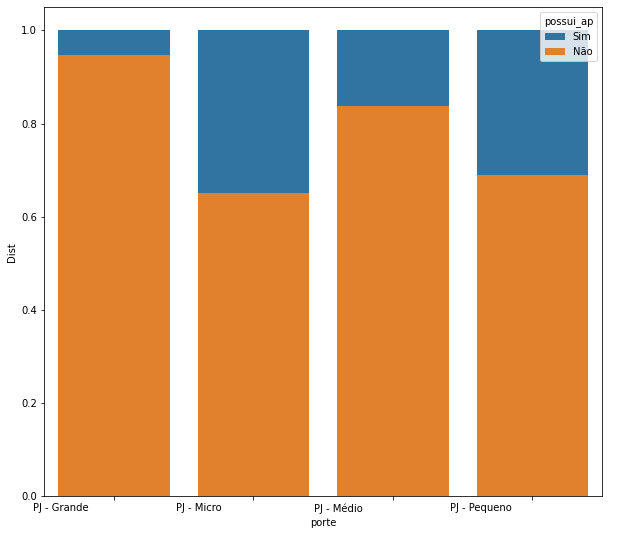

In [11]:
# calcular a distribuição de `porte` por `possui_ap`
distribution = pd.crosstab(df.porte, df.possui_ap, normalize='index')

plt.figure( figsize=(10, 9))

# plotar o cumsum, com hue order reverso
sns.barplot(data=distribution.cumsum(axis=1).stack().reset_index(name='Dist'),
            x='porte', y='Dist', hue='possui_ap',
            hue_order = distribution.columns[::-1],   
            dodge=False);

In [12]:
df2 = df.groupby(['cnae_secao', 'possui_ap'])['possui_ap'].count()
df3 = df2.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
print(df3)

cnae_secao                                                             possui_ap
PJ - Administração pública, defesa e seguridade social                 Não          91.886792
                                                                       Sim           8.113208
PJ - Agricultura, pecuária, produção florestal, pesca e aqüicultura    Não          84.869199
                                                                       Sim          15.130801
PJ - Alojamento e alimentação                                          Não          53.941228
                                                                       Sim          46.058772
PJ - Artes, cultura, esporte e recreação                               Não          67.983393
                                                                       Sim          32.016607
PJ - Atividades administrativas e serviços complementares              Não          67.460455
                                                                       Si

Acima vemos a porcentagem de inadimplentes agrupados por CNAE da empresa, e temos alguns cnaes com maior porcentagem de inadimplência.
 - 1: PJ - Alojamento e alimentação com **46.07%** de inadimplentes
 - 2: PJ - Serviços domésticos com **44.79%** de inadimplentes
 - 3: PJ - Outras atividades de serviços com **35.30%** de inadimplentes
 
 E os menores indices são:
 - 3: PJ - Indústrias extrativas com **14.33%** de inadimplentes
 - 2: PJ - Eletricidade e gás com **8.30%** de inadimplentes
 - 1: Administração pública, defesa e seguridade social com **8.11%** de inadimplentes


Abaixo vemos o mesmo indice porém em gráfico de barras. Onde podemos notar também a quantidade maio r de empresas com CNAE PJ - Comércio; reparação de veículos automotores e motocicletas

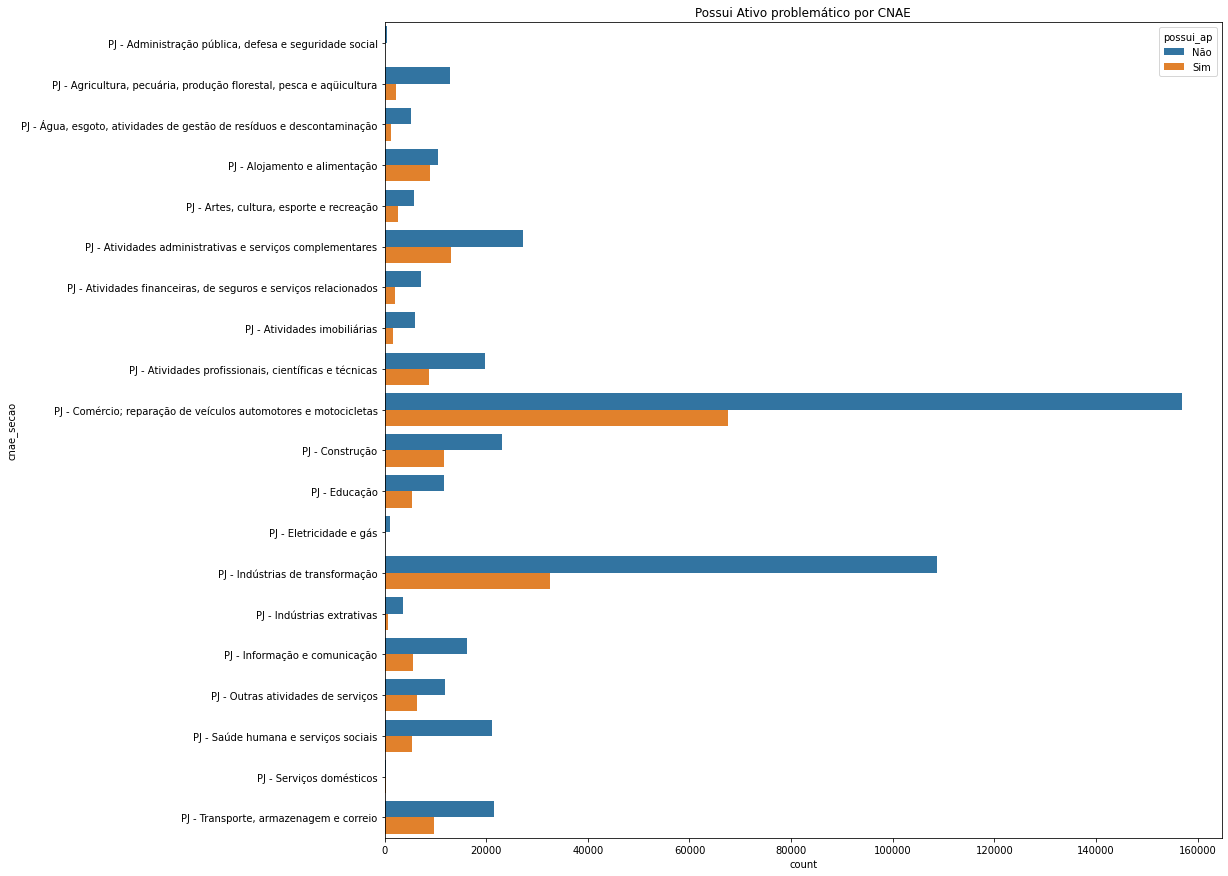

In [13]:
f, ax = plt.subplots(figsize=(15, 15))
sns.countplot(y="cnae_secao", hue='possui_ap', data=df).set_title('Possui Ativo problemático por CNAE');

Vamos verificar também um gráfico de distribuição dos inadimplentes por UF. E podemos verificar que o estado com maior indice de inadimplência é o RJ e o menor é TO.

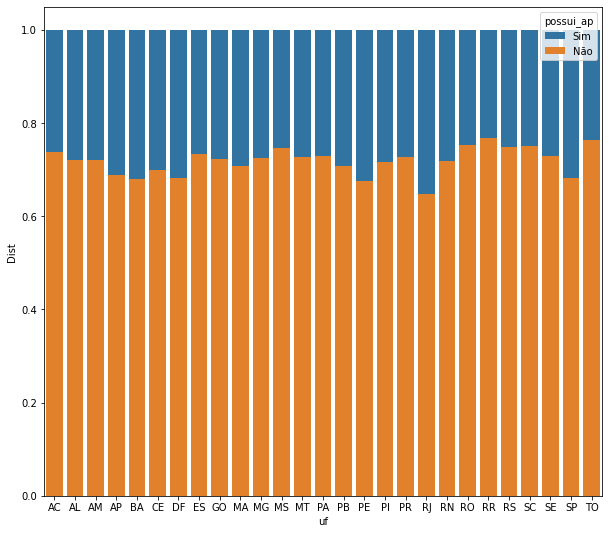

In [14]:
# calcular a distribuição de `estado` por `possui_ap`
distribution = pd.crosstab(df.uf, df.possui_ap, normalize='index')

plt.figure( figsize=(10, 9)) 

# plotar o cumsum, com hue order reverso
sns.barplot(data=distribution.cumsum(axis=1).stack().reset_index(name='Dist'),
            x='uf', y='Dist', hue='possui_ap',
            hue_order = distribution.columns[::-1],   
            dodge=False);

## Transformação de variáveis categóricas em numéricas

Os modelos de machine learning trabalham basicamente com a Matemática, e para fazer os calculos os algoritmos precisam de valores numéricos. Porém nosso DataFrame possuem valores em texto o que chamamos de categóricos.

Então nessa etapa vamos transformar esses dados categóricos em numéricos para os modelos de machine learning.

Utilizamos a técnica de Label Enconder, onde os textos são substituídos por números. Por exemplo, ‘A’ virará 0, ‘B’ virará 1, ‘C’ virará 2 ...

In [15]:
from sklearn.preprocessing import LabelEncoder
let = LabelEncoder()

df['uf'] = let.fit_transform(df['uf'])
df['tcb'] = let.fit_transform(df['tcb'])
df['sr'] = let.fit_transform(df['sr'])
df['cnae_secao'] = let.fit_transform(df['cnae_secao'])
df['porte'] = let.fit_transform(df['porte'])
df['origem'] = let.fit_transform(df['origem'])
df['modalidade'] = let.fit_transform(df['modalidade'])
df['indexador'] = let.fit_transform(df['indexador'])
df['possui_v15'] = let.fit_transform(df['possui_v15'])
df['possui_cia'] = let.fit_transform(df['possui_cia'])
df['possui_ap'] = let.fit_transform(df['possui_ap'])
df.head()

,uf,tcb,sr,cnae_secao,porte,modalidade,origem,indexador,numero_de_operacoes,possui_v15,possui_cia,possui_ap
0,0,0,0,0,1,0,1,0,1,0,0,0
1,0,0,0,0,1,3,0,0,1,0,0,0
2,0,0,0,0,1,3,0,3,1,0,0,0
3,0,0,0,0,3,1,1,2,1,0,0,0
4,0,0,0,0,3,7,1,2,1,1,0,0


In [16]:
df.dtypes

uf                     int64
tcb                    int64
sr                     int64
cnae_secao             int64
porte                  int64
modalidade             int64
origem                 int64
indexador              int64
numero_de_operacoes    int64
possui_v15             int64
possui_cia             int64
possui_ap              int64
dtype: object

Abaixo vemos a correlação ente as variáveis.

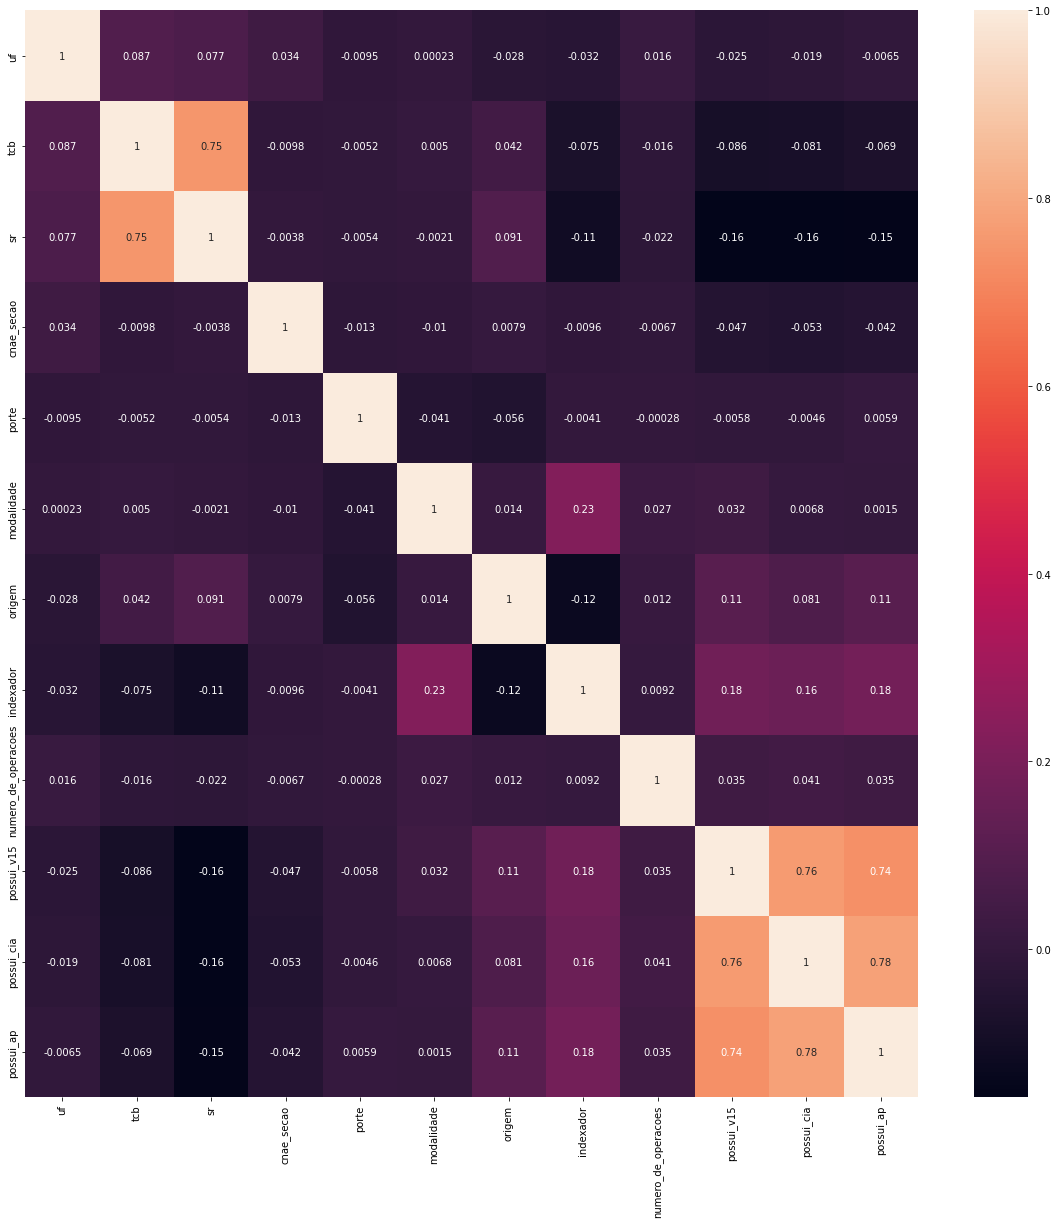

In [17]:
correlations = df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True);

Aqui utilizamos a biblioteca SweetViz que nos ajuda na hora de fazer a análise exploratória de dados.

Essa biblioteca de código aberto apresenta uma visualização rápida dos principais dados com comparação entre eles.

In [18]:
# Sweetviz
my_report = sv.analyze(df,"possui_ap")
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Nosso DataFrame possui algumas linhas duplicadas, portanto vamos tratá-las e removê-las. Val;e ressaltar que essa remoção de linhas duplicadas não foram removidas antes pois estavam interferindo na parte de análise exploratória.

In [19]:
df.duplicated().sum()

422395

In [20]:
df = df.drop_duplicates()

In [21]:
df.duplicated().sum()

0

In [22]:
df.shape

(234563, 12)

# Treinando e avaliando modelos

Nosso modelo vai tentar prever se uma empresa será inadimplente ou não. No nosso DataFrame isso é representado pela coluna 'possui_ap', portanto essa coluna será nosso 'target', ou seja, o com base nos outros dados o algoritmo fará os calculos e tentará prever se a empresa será inadimplente ou não.

In [23]:
# Separando os conjuntos de dados.
target_name = 'possui_ap'
X = df.drop('possui_ap', axis=1)
y = df[target_name]

O nosso DataFarme possui valores de várias escalas, valores que vão desde 0 até mais de 1.000.000 o que é um pode se tornar um problema para o modelo de achine learning. Então vamos fazer um processo de normalização.

A normalização é uma técnica geralmente aplicada como parte da preparação de dados para o aprendizado de máquina. O objetivo da normalização é mudar os valores das colunas numéricas no conjunto de dados para usar uma escala comum, sem distorcer as diferenças nos intervalos de valores nem perder informações. A normalização também é necessária para alguns algoritmos para modelar os dados corretamente.

Vamos utilizar a técnica MinMaxScaler do Sklearn que coloca os dados na mesma escala.

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Poderíamos utilizar a totalidade dos dados históricos no processo acima, criando assim um modelo de machine learning pronto para receber novos dados e realizar suas previsões, porém desta forma não saberíamos o real desempenho deste modelo. O algoritmo poderia aprender perfeitamente a relação existentes nos dados apresentados e com isso criar um modelo que sofre de Overfitting e só descobriríamos esse problema após as previsões desastrosas geradas por este modelo.

Desta forma, para medir o desempenho real do modelo criado, é necessário que realizemos testes com ele, utilizando dados diferentes dos que foram apresentados em sua criação.

Com esta finalidade, após a realização do pré-processamento, iremos separar a totalidade dos dados históricos existentes em dois grupos, sendo o primeiro responsável pelo aprendizado do modelo, e o segundo por realizar os testes.

**Dados de Treino**
Conforme podemos imaginar, dados de treino são os dados que serão apresentados ao algoritmo de machine learning para criação do modelo. Estes dados costumam representar cerca de 70% da totalidade dos dados.

**Dados de Teste**
Serão apresentados ao modelo após a sua criação, simulando previsões reais que o modelo realizará, permitindo assim que o desempenho real seja verificado. Estes dados costumam representar cerca de 30% da totalidade dos dados.

In [25]:
# Dividindo o conjunto de dados em conjunto de treinamento e conjunto de teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### Importando métodos de métrica de avaliação.

Uma etapa importante para saber se estamos no caminho correto e realizar a avaliação de algumas métricas.

Vamos definir quais serão as métricas que iremos utilizar.
- Primeiro vamos verificar a acurácia que é é a proximidade de um resultado com o seu valor de referência real. Dessa forma, quanto maior o nível de acuracidade, mais próximo da referência ou valor real é o resultado encontrado.
 
- Também vamos ver o classification report que exibe as pontuações de Precision, Recall, F1 e Support para o modelo.
 
     **Precision** pode ser vista como uma medida da exatidão de um classificador. Para cada classe, é definido como a razão de verdadeiros positivos para a soma de verdadeiros e falsos positivos. Dito de outra forma, “para todas as instâncias classificadas como positivas, qual porcentagem estava correta”
      
     **Recall** é uma medida da completude do classificador; a capacidade de um classificador para encontrar corretamente todas as instâncias positivas. Para cada classe, é definida como a razão de verdadeiros positivos para a soma de verdadeiros positivos e falsos negativos. Dito de outra forma, “para todas as instâncias que foram realmente positivas, qual porcentagem foi classificada corretamente?”
      
     **F1 score** é uma média harmônica ponderada de precisão e rechamada tal que o melhor escore é 1,0 e o pior é 0,0. De um modo geral, os escores F 1 são mais baixos do que as medidas de precisão, pois incorporam precisão e recall em seus cálculos. Como regra geral, a média ponderada de F 1 deve ser usada para comparar modelos de classificadores, não a precisão global.
      
     **Support** é o número de ocorrências reais da classe no conjunto de dados especificado. O suporte desequilibrado nos dados de treinamento pode indicar fraquezas estruturais nas pontuações relatadas do classificador e pode indicar a necessidade de amostragem estratificada ou rebalanceamento. O suporte não muda entre os modelos, mas diagnostica o processo de avaliação.
     
      
- A confusion matrix é uma tabela que permite extrair métricas que auxiliam na avaliação de modelos de machine learning para classificação, ela classifica em:
 
     - Verdadeiro Positivo (VP): falou que seria, e foi.
     - Verdadeiro Negativo (VN): falou que não seria, e não foi.
     - Falso Positivo (FP): falou que seria, mas não foi.
     - Falso Negativo (FN): falou que não seria, mas foi.
     
     
- A curva ROC mostra o quão bom o modelo criado pode distinguir entre duas coisas (já que é utilizado para classificação). Essas duas coisas podem ser 0 ou 1, ou positivo e negativo. 

 > O ROC possui dois parâmetros:
   > - Taxa de verdadeiro positivo (True Positive Rate), que é dado por VP / (VP + FN)
   > - Taxa de falso positivo (False Positive Rate), que é dado por FP / (FP + VN)
 > - Uma curva ROC traça “True Positive Rate vs. False Positive Rate” em diferentes limiares de classificação

- Assim, na tentativa de simplificar a análise da ROC, a AUC (“Area Under the ROC Curve”) nada mais é que uma maneira de resumir a curva ROC em um único valor, agregando todos os limiares da ROC, calculando a “área sob a curva”. AUC varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe. Quanto maior o AUC, melhor.
 

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [27]:
def accuracy_result(model, y_test,y_predict):
    acc = accuracy_score(y_test, y_predict)
    print (f"{model} Accuracy = %2.6f" % acc)

In [28]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

In [29]:
def cm_result(y_test,y_predict):
    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt='g');

In [30]:
def plot_roc_curve(y_true, y_score):
        
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.4}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taxa positiva falsa')
    plt.ylabel('Taxa positiva verdadeira')
    plt.title('Curva Roc')
    plt.legend(loc="lower right")

# Previsão

Primeiramente vamos utilizar o método de previsão .predict(), que vai analisar os dados e retornar se a empresa será inadimplente ou não, ou seja, é um retorno binário (Sim, Não)

## Random Forest

Um algoritmo de aprendizado de máquina supervisionado. É um dos algoritmos mais utilizados devido à sua precisão, simplicidade e flexibilidade. O fato de poder ser usado para tarefas de classificação e regressão, combinado com sua natureza não linear, torna-o altamente adaptável a uma variedade de dados e situações.

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf = rf.fit(X_train,y_train)

In [32]:
y_predict = rf.predict(X_test)

In [33]:
accuracy_result("Random Forest", y_test, y_predict)

Random Forest Accuracy = 0.798244


In [34]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.7977582483825736

              precision    recall  f1-score   support

           0       0.79      0.82      0.81     23960
           1       0.81      0.78      0.79     22953

    accuracy                           0.80     46913
   macro avg       0.80      0.80      0.80     46913
weighted avg       0.80      0.80      0.80     46913



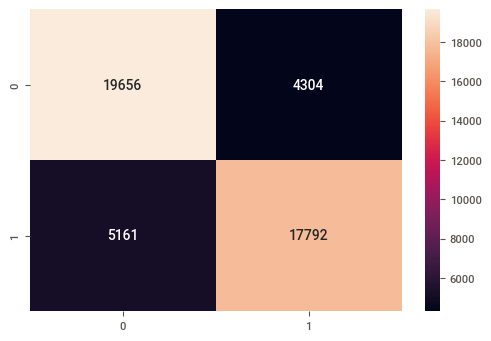

In [35]:
cm_result(y_test, y_predict)

## XGBoost

O nome XGBoost vem de eX*treme *Gradient Boosting, e representa uma categoria de algoritmo baseada em Decision Trees (árvores de decisão) com Gradient Boosting (aumento de gradiente).

Aumento de gradiente significa que o algoritmo usa o algoritmo Gradient Descent para minimizar a perda (loss) enquanto novos modelos vão sendo adicionados.

Extremamente flexível – uma vez que possui um grande número de hiperparâmetros passíveis de aperfeiçoamento -, você consegue ajustar adequadamente o XGBoost para o cenário do seu problema, seja ele qual for.

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb = xgb.fit(X_train,y_train)

[11:40:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
y_predict = xgb.predict(X_test)

In [38]:
accuracy_result("XGBClassifier", y_test, y_predict)

XGBClassifier Accuracy = 0.864174


In [39]:
roc_classification_report_results("XGBClassifier", y_test, y_predict)


XGBClassifier AUC = 0.8626640428466475

              precision    recall  f1-score   support

           0       0.82      0.93      0.88     23960
           1       0.92      0.79      0.85     22953

    accuracy                           0.86     46913
   macro avg       0.87      0.86      0.86     46913
weighted avg       0.87      0.86      0.86     46913



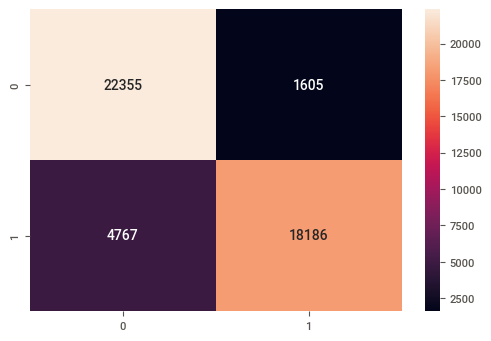

In [40]:
cm_result(y_test, y_predict)

## Comparando os modelos

In [41]:
comp = { 'Models' : ['Random Forest', 'XGBClassifier'],
         'Test Accuracy' : [round(rf.score(X_test,y_test)*100,2), round(xgb.score(X_test,y_test)*100,2)],
         'Train Accuracy': [round(rf.score(X_train,y_train)*100,2), round(xgb.score(X_train,y_train)*100,2)]
       }

compdf = pd.DataFrame(comp)
compdf.sort_values(by='Test Accuracy',ascending=False)

,Models,Test Accuracy,Train Accuracy
1,XGBClassifier,86.42,86.87
0,Random Forest,79.82,94.42


# Probabilidades

Agora vamos utilizar o método de previsão de probabilidade .predict_proba(), que vai analisar os dados e retornar a probabilidade da empresa se tornar inadimplente.

## Random Forest

In [42]:
y_proba = rf.predict_proba(X_test)[: , 1]

In [43]:
roc_auc_score(y_test, y_proba)

0.8932691746806113

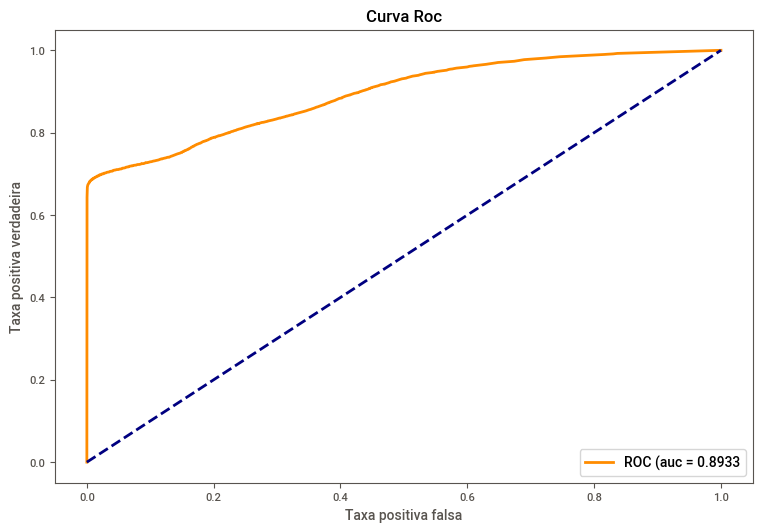

In [44]:
plot_roc_curve(y_true=y_test, y_score=y_proba)

## XGBoost

In [45]:
y_proba = xgb.predict_proba(X_test)[: , 1]

In [46]:
roc_auc_score(y_test, y_proba)

0.9404161145294583

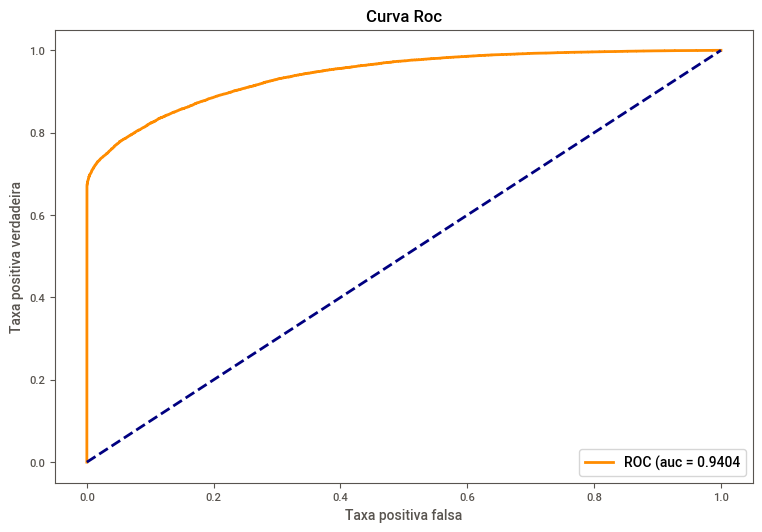

In [47]:
plot_roc_curve(y_true=y_test, y_score=y_proba)

# Conclusão

Neste projeto, trabalhamos com um problema de identificação de risco de crédito com objetivo de construir um modelo de machine learning capaz de identificar possíveis inadimplentes.

Utilizamos o método predict onde o algoritmo apresenta o rótulo 0 ou 1, ou seja, a empresa será inadimplente ou não. 

Depois utilizamos o método predict_proba para prever a probabilidade de inadimplência. Desta forma, em uma situação real, a instuição cedente do crédito seria capaz de estipular os juros com base na probabilidade de cada aplicação, diferenciando de maneira mais eficiente a sua base de clientes. 

Nos dois casos, o modelo que melhor se adequou foi o XGBoost, portanto este seria o modelo escolhido para a empresa prever dentre aos novos dados de consumidores quais podem ser inadimplentes, direcionando ações que busquem minimizar estas perdas.

Termino esse trabalho agradecendo a todos que me apoiaram e me auxiliaram para conclusão desse Trabalho e Curso:

Minha família por compreender minhas ausências devido ao tempo dedicado ao curso.

Marcelo Bianchi, meu professor no curso de Data Science, por ser uma excepcional educador, fazendo aulas interessantes com diversos exemplos que estimulem aos alunos.

A Awari pelo material, plataforma e equipe fora de série.

Deixo aqui meu Muito Obrigado e meus contatos abaixo.